# Air bnb price prediction

## Installing requirements

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import load_model
import re 

## Data preprocessing

In [2]:
df = pd.read_csv('/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/train_airbnb_berlin.csv', sep=',')
df[df == "*"] = np.nan

### Preliminary analysis

Let's analyze the proportion of missing values.

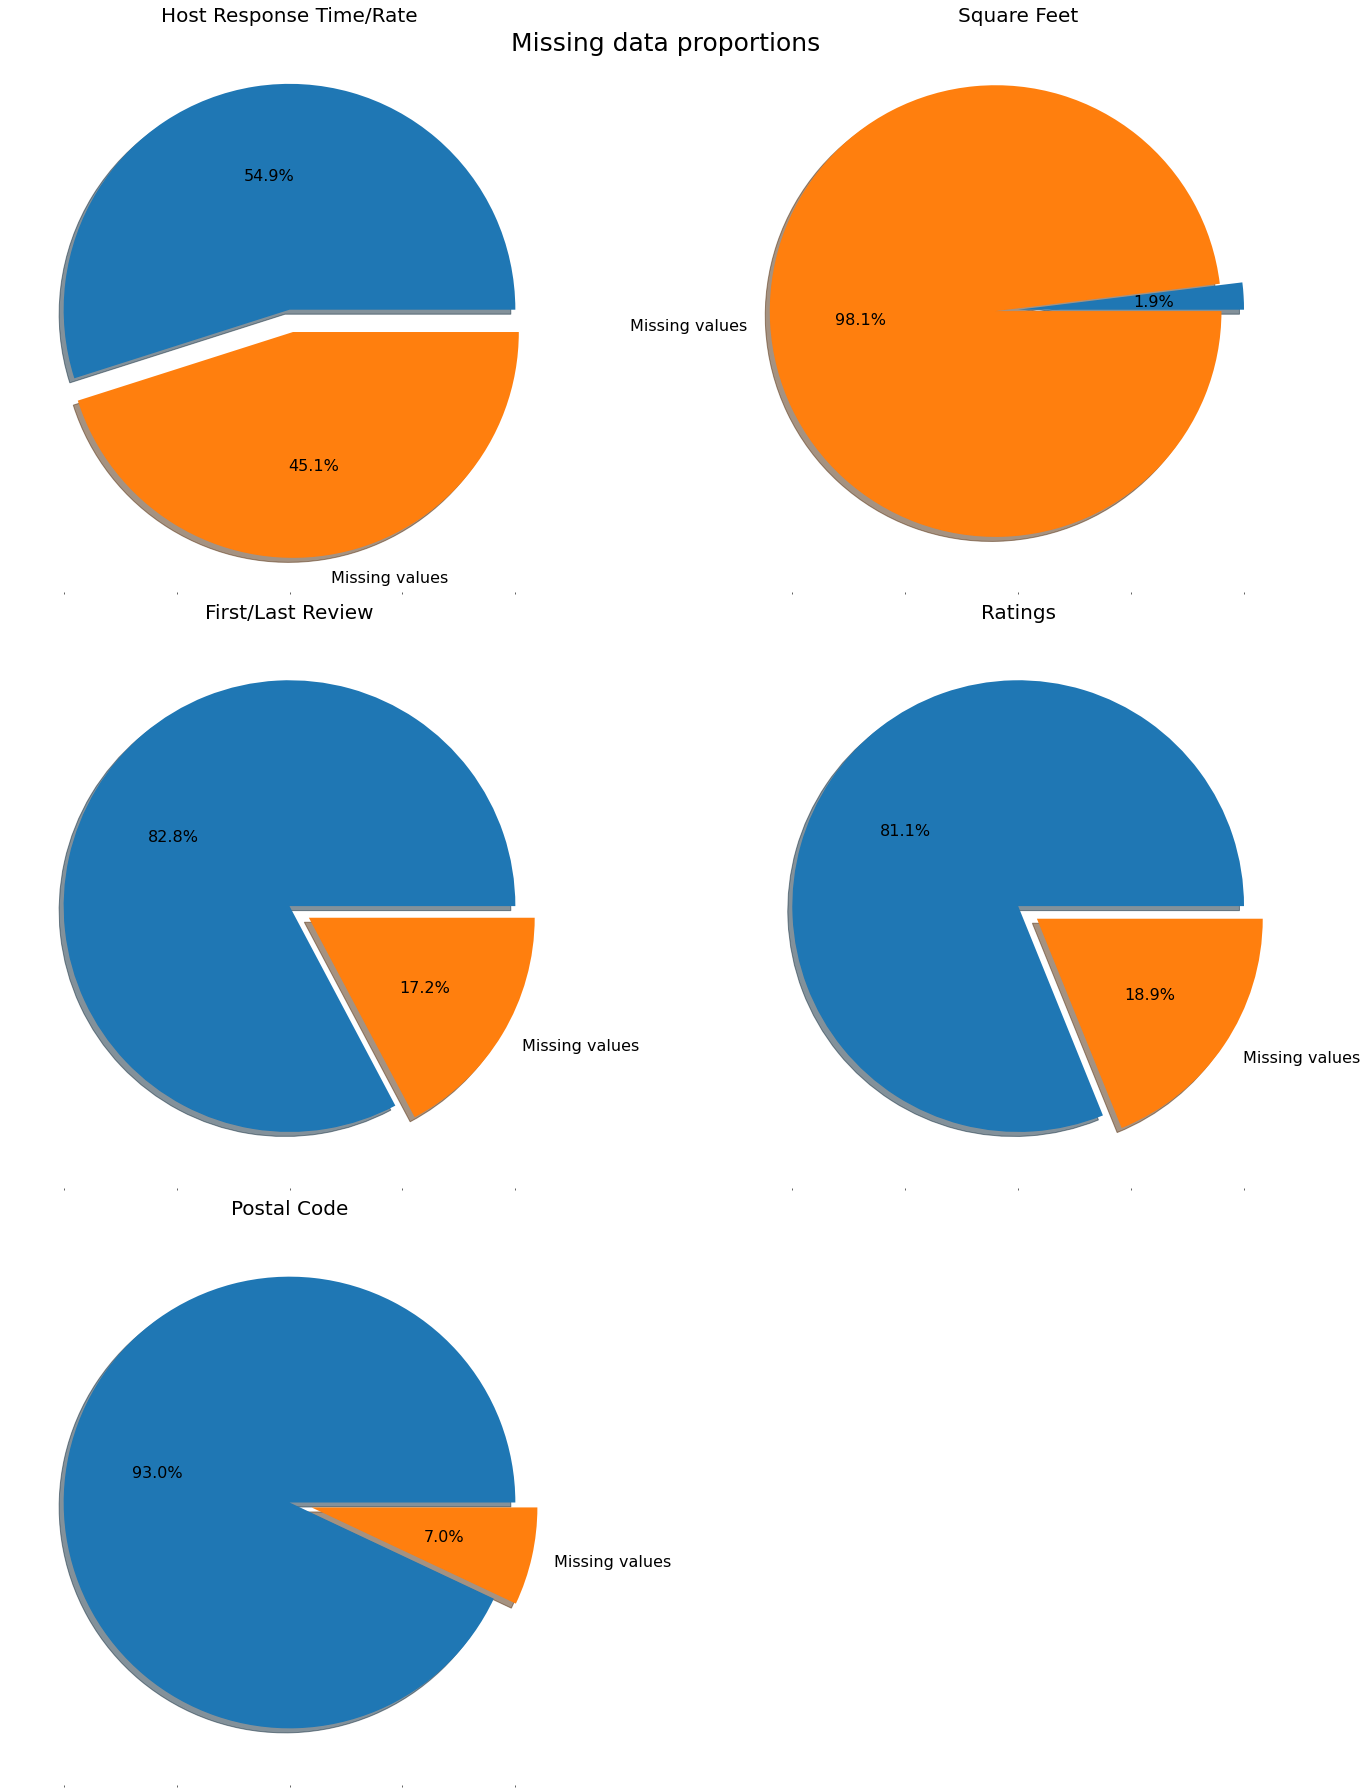

In [3]:
import matplotlib.pyplot as plt

HRT = pd.Series({'':df["Host Response Time"].shape[0]-df["Host Response Time"].isna().sum(), 'Missing values': df["Host Response Time"].isna().sum()})
SQR_FT = pd.Series({'':df["Square Feet"].shape[0]-df["Square Feet"].isna().sum(), 'Missing values': df["Square Feet"].isna().sum()})
FL_RVW = pd.Series({'':df["First Review"].shape[0]-df["First Review"].isna().sum(), 'Missing values': df["First Review"].isna().sum()})
OVR_RATING = pd.Series({'':df["Overall Rating"].shape[0]-df["Overall Rating"].isna().sum(), 'Missing values': df["Overall Rating"].isna().sum()})
POSTAL = pd.Series({'':df["Postal Code"].shape[0]-df["Postal Code"].isna().sum(), 'Missing values': df["Postal Code"].isna().sum()})

df_subplot = pd.concat([HRT, SQR_FT, FL_RVW, OVR_RATING, POSTAL], axis=1, 
                       keys=['','','','','','']
                                                                          
                       )

#axes = df_subplot.plot(kind='pie', subplots=True, figsize=(20,20), \
#                      explode = (0, 0.1))

axes = df_subplot.plot(kind='pie', subplots=True, grid=True,
        layout=(3, 2), legend=False, explode = (0,0.1), shadow =True,
        figsize=(20,25), fontsize= 16, autopct='%1.1f%%', startangle=0
        )

axes[0][0].set_title('Host Response Time/Rate', fontsize=20)
axes[0][1].set_title('Square Feet', fontsize=20)
axes[1][0].set_title('First/Last Review', fontsize=20)
axes[1][1].set_title('Ratings', fontsize=20)
axes[2][0].set_title('Postal Code', fontsize=20)


plt.suptitle("Missing data proportions",  
             fontsize=25)
plt.tight_layout()
plt.show()

In [4]:
df.isna().sum()

Listing ID                   1
Listing Name             15692
Host ID                      0
Host Name                   22
Host Since                  21
Host Response Time        7075
Host Response Rate        7249
Is Superhost                23
neighbourhood              203
Neighborhood Group           0
City                        48
Postal Code               1099
Country Code                 0
Country                      0
Latitude                     0
Longitude                    0
Is Exact Location            0
Property Type               75
Room Type                    0
Accomodates                 19
Bathrooms                   25
Bedrooms                    16
Beds                        20
Square Feet              15389
Guests Included             10
Min Nights                 249
Reviews                      0
First Review              2705
Last Review               2706
Overall Rating            2962
Accuracy Rating           2971
Cleanliness Rating        2970
Checkin 

### Preprocess function

In [3]:
# Let's take out features that are deemed useless in the price prediction.

def preprocess_data_preliminary(df):
    df_clean = df.drop(["Host Name",
                        "Host ID",
                        "Listing ID",
                        "Listing Name",
                        "neighbourhood",
                        "Neighborhood Group",
                        "City",
                        "Country Code",
                        "Country",
                        "Postal Code",
                        "Square Feet", 
                        "First Review",
                        "Last Review",
                        "Business Travel Ready"], axis=1)


    # Dropping NaNs where it doesn't pose a problem. Merely 3% of the entire dataset.

    df_clean = df_clean.dropna(subset=["Host Since",
                                      "Is Superhost",
                                      "Property Type",
                                      "Accomodates",
                                      "Bathrooms",
                                      "Bedrooms",
                                      "Beds",
                                      "Guests Included",
                                      "Min Nights",
                                      "Price"])

    # Let's fill NaN values by "unknown" where we can.  

    df_clean.loc[df_clean['Host Response Time'].isna(), "Host Response Time"]='unknown'

    # Replacing binary values by 0 and 1

    df_clean.loc[df_clean["Is Superhost"]=='t', "Is Superhost"]=1
    df_clean.loc[df_clean["Is Superhost"]=='f', "Is Superhost"]=0
    df_clean["Is Superhost"]=df_clean["Is Superhost"].astype(float)    

    df_clean.loc[df_clean["Is Exact Location"]=='t', "Is Exact Location"]=1
    df_clean.loc[df_clean["Is Exact Location"]=='f', "Is Exact Location"]=0
    df_clean["Is Exact Location"]=df_clean["Is Superhost"].astype(float)    

    df_clean.loc[df_clean["Instant Bookable"]=='t', "Instant Bookable"]=1
    df_clean.loc[df_clean["Instant Bookable"]=='f', "Instant Bookable"]=0
    df_clean["Instant Bookable"]=df_clean["Is Superhost"].astype(float)

    # Converting into float certain features were apparently value isn't seen as numeric

    df_clean["Accomodates"]=df_clean["Accomodates"].astype(float)
    df_clean["Bathrooms"]=df_clean["Bathrooms"].astype(float)
    df_clean["Bedrooms"]=df_clean["Bedrooms"].astype(float)      
    df_clean["Beds"]=df_clean["Beds"].astype(float)          
    df_clean["Guests Included"]=df_clean["Guests Included"].astype(float)
    df_clean["Min Nights"]=df_clean["Min Nights"].astype(float)

    # String to float for response rate.
    df_clean["Host Response Rate"] = df_clean["Host Response Rate"].str.rstrip("%").astype(float)

    # Changing host since into continous form.

    df_clean["Host Since"] = pd.to_datetime(df_clean["Host Since"])
    most_recent =  max(df_clean["Host Since"])
    seniority = [(most_recent-x).days for x in df_clean["Host Since"]]
    df_clean["Host Since"] = seniority

    # One-hot encoding for categorical values

    dummies_response_time  = pd.get_dummies(df_clean[["Host Response Time"]])
    dummies_property_type = pd.get_dummies(df_clean[["Property Type"]])
    dummies_room_type = pd.get_dummies(df_clean[["Room Type"]])
  

    X_ = df_clean.drop(["Host Response Time", "Property Type", "Room Type"],axis=1)
    df_clean_final = pd.concat([X_, dummies_response_time, dummies_property_type, dummies_room_type], axis=1)

    return df_clean_final

In [4]:
df_clean = preprocess_data_preliminary(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff45dd8e410>,
      dtype=object)

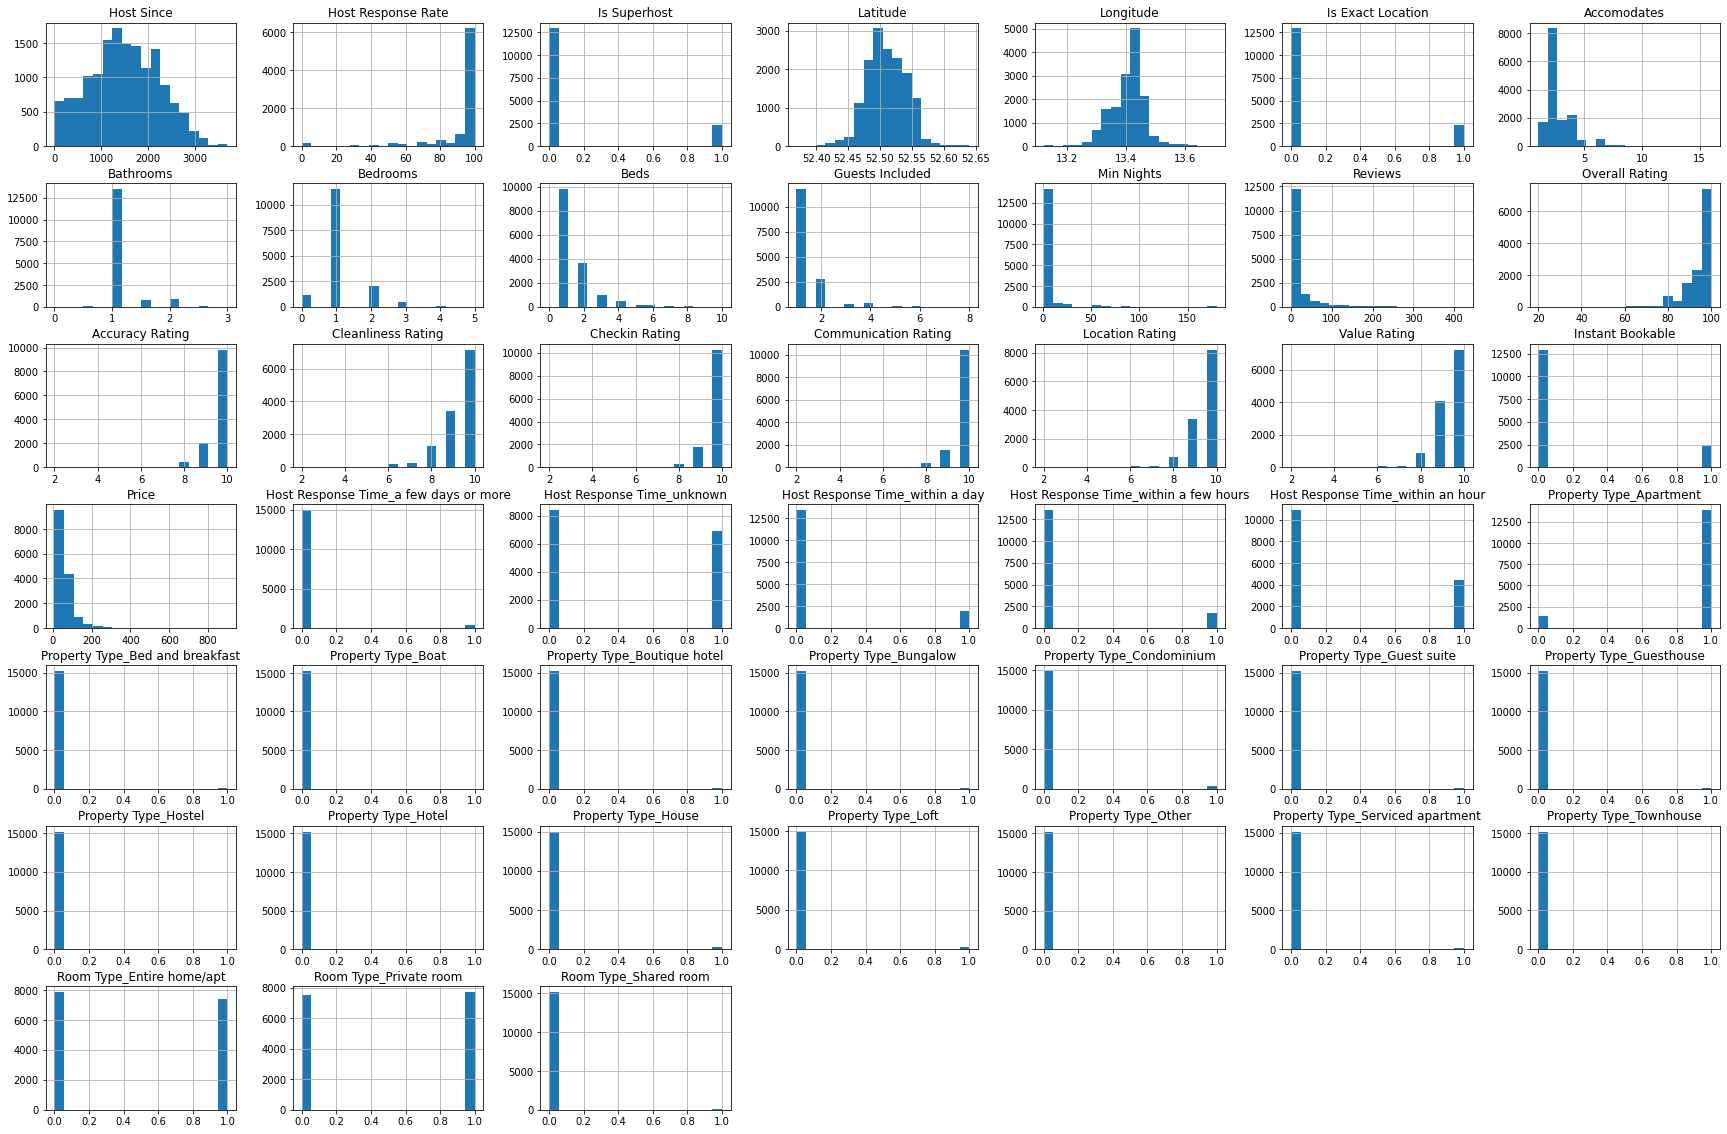

In [39]:
df_clean.hist(figsize=(30,20),bins=18)

In [5]:
df_clean.isna().sum()

Host Since                                  0
Host Response Rate                       7066
Is Superhost                                0
Latitude                                    0
Longitude                                   0
Is Exact Location                           0
Accomodates                                 0
Bathrooms                                   0
Bedrooms                                    0
Beds                                        0
Guests Included                             0
Min Nights                                  0
Reviews                                     0
Overall Rating                           2817
Accuracy Rating                          2826
Cleanliness Rating                       2825
Checkin Rating                           2828
Communication Rating                     2825
Location Rating                          2826
Value Rating                             2827
Instant Bookable                            0
Price                             

### For later

In [ ]:
def preprocess_data_phase2(df):

    avg_response_rate = float('{:.2f}'.format(df_clean["Host Response Rate"].mean()))
    df_clean.loc[df_clean['Host Response Rate'].isna(), "Host Response Rate"]=avg_response_rate


        # For ratings
    df_clean["Overall Rating"] = df_clean["Overall Rating"]/100
    df_clean.loc[df_clean['Overall Rating'].isna(), "Overall Rating"]=df_clean["Overall Rating"].mean()

    df_clean["Accuracy Rating"] = df_clean["Accuracy Rating"]/10
    df_clean.loc[df_clean['Accuracy Rating'].isna(), "Accuracy Rating"]=df_clean["Accuracy Rating"].mean()

    df_clean["Cleanliness Rating"] = df_clean["Cleanliness Rating"]/10
    df_clean.loc[df_clean['Cleanliness Rating'].isna(), "Cleanliness Rating"]=df_clean["Cleanliness Rating"].mean()

    df_clean["Checkin Rating"] = df_clean["Checkin Rating"]/10
    df_clean.loc[df_clean['Checkin Rating'].isna(), "Checkin Rating"]=df_clean["Checkin Rating"].mean()

    df_clean["Communication Rating"] = df_clean["Communication Rating"]/10
    df_clean.loc[df_clean['Communication Rating'].isna(), "Communication Rating"]=df_clean["Communication Rating"].mean()

    df_clean["Location Rating"] = df_clean["Location Rating"]/10
    df_clean.loc[df_clean['Location Rating'].isna(), "Location Rating"]=df_clean["Location Rating"].mean()

    df_clean["Value Rating"] = df_clean["Value Rating"]/10
    df_clean.loc[df_clean['Value Rating'].isna(), "Value Rating"]=df_clean["Value Rating"].mean()



Let's add a feature: we process the host names through an NLP model to determine whether the host is a male or female.

In [ ]:
# Renaming  

## Loadings 
pred_model = load_model('boyorgirl.h5')

## preprocess 

def preprocess(names_df):

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if type(x)!=type('hello') else x)
    print(names_df['Host Name'] )

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if  bool(re.match("^[A-Za-z0-9_-]*$",x))==False else x)
    print(names_df['Host Name'])

    names_df['name']= names_df['Host Name']
    names_df['name'] = names_df['name'].str.lower()

    names_df['name'] = [list(name) for name in names_df['name']]

    name_length = 50
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]

    names_df['name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['name']
    ]

    return names_df


### prediction 

df_clean_renamed = preprocess(df_clean)

result = pred_model.predict(np.array(df_clean_renamed['name'].tolist()))

df_clean_renamed['Boy or Girl?'] = [
        'Boy' if logit > 0.5 else 'Girl' for logit in result
    ]

df_clean_renamed.drop('name', axis=1, inplace=True)

dummies_gender = pd.get_dummies(df_clean_renamed[["Boy or Girl?"]])


0        Maximilian
1             Dulie
2             Geank
3              Alix
4            Lurina
            ...    
15687       Ascharl
15688         Marki
15689           Ada
15690         Lanna
15691        OloreA
Name: Host Name, Length: 15268, dtype: object
0        Maximilian
1             Dulie
2             Geank
3              Alix
4            Lurina
            ...    
15687       Ascharl
15688         Marki
15689           Ada
15690         Lanna
15691        OloreA
Name: Host Name, Length: 15268, dtype: object
478/478 [==============================] - 25s 50ms/step


In [ ]:
df_clean_renamed.drop('Host ID', axis=1, inplace=True)
df_clean_renamed.reset_index(drop="True", inplace=True)

Now, let's convert features with classes by using pandas dummies function.

In [ ]:
dummies_response_time  = pd.get_dummies(df_clean_renamed[["Host Response Time"]])
dummies_property_type = pd.get_dummies(df_clean_renamed[["Property Type"]])
dummies_room_type = pd.get_dummies(df_clean_renamed[["Room Type"]])
dummies_gender = pd.get_dummies(df_clean_renamed[["Boy or Girl?"]])

X_ = df_clean_renamed.drop(["Host Response Time", "Property Type", "Room Type", "Boy or Girl?"],axis=1)
df_clean_final = pd.concat([X_, dummies_response_time, dummies_property_type, dummies_room_type, dummies_gender], axis=1)

### Saving preprocessed data

In [40]:
df_clean.to_csv("/content/train_airbnb_berlin_preprocessed_phase1.csv", sep=";", index=False)

## Train test split

In [6]:
from sklearn.model_selection import train_test_split

X = df_clean.drop("Price",axis=1)
y = df_clean["Price"].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)


# KNN Regressor

## Missing value imputation & Scaling

Moving on, the strategy will be to make several versions of the processed data, so as to determine which type of processing yields the best results !

For imputing values, let's try two types of univariate imputation for now:
- mean
- median
- most frequent

For scaling:
- Minmax on every numeric data
- standard scaling on every numeric data

We're going to create the 6 pipelines that correspond to each combination:
- mn_minmax
- mdn_minmax
- mf_minmax
- mn_std
- mdn_std
- mf_std



### First approach

In [54]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pipelines for numeric values

num_pipeline_mn_minmax = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mdn_minmax = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mf_minmax = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mn_std = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mdn_std = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mf_std = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler())
])

# Let's get the list of numerical features.
numeric_features = ['Host Since',
                    'Host Response Rate',
                    'Latitude',
                    'Longitude',
                    'Accomodates',
                    'Bathrooms',
                    'Bedrooms',
                    'Beds',
                    'Guests Included',
                    'Min Nights',
                    'Reviews',
                    'Overall Rating',
                    'Accuracy Rating',
                    'Cleanliness Rating',
                    'Checkin Rating',
                    'Communication Rating',
                    'Location Rating',
                    'Value Rating'
                    ]

airbnb_data_transformer_1 = ColumnTransformer([
    ("num_mn_minmax", num_pipeline_mn_minmax, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_2 = ColumnTransformer([
    ("num_mdn_minmax", num_pipeline_mdn_minmax, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_3 = ColumnTransformer([
    ("num_mf_minmax", num_pipeline_mf_minmax, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_4 = ColumnTransformer([
    ("num_mn_std", num_pipeline_mn_std, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_5 = ColumnTransformer([
    ("num_mdn_std", num_pipeline_mdn_std, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_6 = ColumnTransformer([
    ("num_mf_std", num_pipeline_mf_std, numeric_features)
],remainder="passthrough")



Now, out of these imputers and scalers, let's see which combination yields the best performance.

We'll keep parameters for KNN Regressor as identical (default), since we're trying to see which preprocessing technique seems best. Hyperparameter tuning will come later.

In [56]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def train_test_knn_regressor(X_train, y_train, X_test, y_test):
    '''Trains and test a KNN regression model on the given training and test set.
    The function prints the RMSE of the predictions on the test set for each
    type of preprocessing (6 combinations to test in total).
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector  with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector  with the values of the target variable of the test instances.

    '''

    # Define the 6 types of full pipelines, combining the above preprocessors with KNN Regressor
    full_pipeline_1 = Pipeline([
      ("data_processing", airbnb_data_transformer_1),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_2 = Pipeline([
      ("data_processing", airbnb_data_transformer_2),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_3 = Pipeline([
      ("data_processing", airbnb_data_transformer_3),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_4 = Pipeline([
      ("data_processing", airbnb_data_transformer_4),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_5 = Pipeline([
      ("data_processing", airbnb_data_transformer_5),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_6 = Pipeline([
      ("data_processing", airbnb_data_transformer_6),
      ("knn_regression", KNeighborsRegressor())
    ])
    
    # Transform the training data and train the KNN regressor.
    full_pipeline_1.fit(X_train, y_train)
    full_pipeline_2.fit(X_train, y_train)
    full_pipeline_3.fit(X_train, y_train)
    full_pipeline_4.fit(X_train, y_train)
    full_pipeline_5.fit(X_train, y_train)
    full_pipeline_6.fit(X_train, y_train)

    # Test the knn regressor on the test data.
    predictions_1 = full_pipeline_1.predict(X_test)
    predictions_2 = full_pipeline_2.predict(X_test)
    predictions_3 = full_pipeline_3.predict(X_test)
    predictions_4 = full_pipeline_4.predict(X_test)
    predictions_5 = full_pipeline_5.predict(X_test)
    predictions_6 = full_pipeline_6.predict(X_test)

    # Compute the prediction error.
    mse_1 =  mean_squared_error(y_test, predictions_1)
    mse_2 =  mean_squared_error(y_test, predictions_2)
    mse_3 =  mean_squared_error(y_test, predictions_3)
    mse_4 =  mean_squared_error(y_test, predictions_4)
    mse_5 =  mean_squared_error(y_test, predictions_5)
    mse_6 =  mean_squared_error(y_test, predictions_6)

    # Print the RMSE.
    print("The RMSE error using pipeline 1 is: ", np.sqrt(mse_1))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 2 is: ", np.sqrt(mse_2))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 3 is: ", np.sqrt(mse_3))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 4 is: ", np.sqrt(mse_4))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 5 is: ", np.sqrt(mse_5))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 6 is: ", np.sqrt(mse_6))
    print("--------------------------- \n")

In [57]:
train_test_knn_regressor(X_train, y_train, X_test, y_test)

The RMSE error using pipeline 1 is:  41.454277287579075
--------------------------- 

The RMSE error using pipeline 2 is:  41.065896060520075
--------------------------- 

The RMSE error using pipeline 3 is:  41.070373103051274
--------------------------- 

The RMSE error using pipeline 4 is:  41.13641640226373
--------------------------- 

The RMSE error using pipeline 5 is:  40.84295140858755
--------------------------- 

The RMSE error using pipeline 6 is:  40.84755886014494
--------------------------- 



From the above results, configurations 5 (median+std scaler) and 6 (most frequent+std scaler) seems to work the best. Let's see what a mix of min-max + std scaling gives.

### 2nd approach

In [62]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pipelines for numeric values

num_pipeline_mn_minmax = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mn_std = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mdn_minmax = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mdn_std = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mf_minmax = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mf_std = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler())
])


# Let's get the list of numerical features that seem to have a Gaussian distribution
numeric_features_gaussian = ['Host Since',
                    'Latitude',
                    'Longitude',
                    ]

# And the remaining which will be processed by Min-max scaling.
numeric_features_nongaussian = [f for f in numeric_features if f not in numeric_features_gaussian]

airbnb_data_transformer_7 = ColumnTransformer([
    ("num_mn_minmax", num_pipeline_mn_minmax, numeric_features_nongaussian),
    ("num_mn_std", num_pipeline_mn_std, numeric_features_gaussian)
],remainder="passthrough")

airbnb_data_transformer_8 = ColumnTransformer([
    ("num_mdn_minmax", num_pipeline_mdn_minmax, numeric_features_nongaussian),
    ("num_mdn_std", num_pipeline_mdn_std, numeric_features_gaussian)
],remainder="passthrough")

airbnb_data_transformer_9 = ColumnTransformer([
    ("num_mf_minmax", num_pipeline_mf_minmax, numeric_features_nongaussian),
    ("num_mf_std", num_pipeline_mf_std, numeric_features_gaussian)
],remainder="passthrough")




In [63]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def train_test_knn_regressor_2(X_train, y_train, X_test, y_test):
    '''Trains and test a KNN regression model on the given training and test set.
    The function prints the RMSE of the predictions on the test set for each
    type of preprocessing (3 combinations to test in total).
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector  with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector  with the values of the target variable of the test instances.

    '''

    # Define the full pipeline, combining the above preprocessors with KNN Regressor
    full_pipeline_7 = Pipeline([
      ("data_processing", airbnb_data_transformer_7),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_8 = Pipeline([
      ("data_processing", airbnb_data_transformer_8),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_9 = Pipeline([
      ("data_processing", airbnb_data_transformer_9),
      ("knn_regression", KNeighborsRegressor())
    ])
    
    # Transform the training data and train the KNN regressor.
    full_pipeline_7.fit(X_train, y_train)
    full_pipeline_8.fit(X_train, y_train)
    full_pipeline_9.fit(X_train, y_train)

    # Test the knn regressor on the test data.
    predictions_7 = full_pipeline_7.predict(X_test)
    predictions_8 = full_pipeline_8.predict(X_test)
    predictions_9 = full_pipeline_9.predict(X_test)

    # Compute the prediction error.
    mse_7 =  mean_squared_error(y_test, predictions_7)
    mse_8 =  mean_squared_error(y_test, predictions_8)
    mse_9 =  mean_squared_error(y_test, predictions_9)

    # Print the RMSE.
    print("The RMSE error using pipeline 7 is: ", np.sqrt(mse_7))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 8 is: ", np.sqrt(mse_8))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 9 is: ", np.sqrt(mse_9))
    print("--------------------------- \n")

In [64]:
train_test_knn_regressor_2(X_train, y_train, X_test, y_test)

The RMSE error using pipeline 7 is:  43.15811444183119
--------------------------- 

The RMSE error using pipeline 8 is:  42.96091688767515
--------------------------- 

The RMSE error using pipeline 9 is:  42.98004242844901
--------------------------- 



Well, this doesn't seem to be ideal. Our hypothesis seems false as all errors are much higher than the ones applying one scaling to everyone. Once again though, we can see that applying mean imputation works the best. 

Let's try one final approach, which is multivariate imputation, with the assumption missing data is MAR. Let's see what kind of result this yields.

### Stochastic imputation

In [21]:
# Multivariate imputing (this cell has run)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

it_imp = IterativeImputer(sample_posterior=True)
X_it_imp = it_imp.fit_transform(pd.concat([X_train,y_train],axis=1))

In [23]:
X_train_imputed = np.delete(X_it_imp,-1,axis=1)

In [36]:
X_train_imputed_df = pd.DataFrame(X_train_imputed,
                                  columns=list(X_train.columns))

In [37]:
X_train_imputed_df.head(5)

,Host Since,Host Response Rate,Is Superhost,Latitude,Longitude,Is Exact Location,Accomodates,Bathrooms,Bedrooms,Beds,...,Property Type_Hostel,Property Type_Hotel,Property Type_House,Property Type_Loft,Property Type_Other,Property Type_Serviced apartment,Property Type_Townhouse,Room Type_Entire home/apt,Room Type_Private room,Room Type_Shared room
0,2477.0,100.0,0.0,52.48081,13.42762,0.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1058.0,100.0,0.0,52.51957,13.34393,0.0,4.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1609.0,100.0,0.0,52.51129,13.38791,0.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1232.0,100.0,0.0,52.48244,13.32018,0.0,3.0,1.5,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1776.0,100.0,0.0,52.53975,13.42679,0.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfec2bbf90>,
      dtype=object)

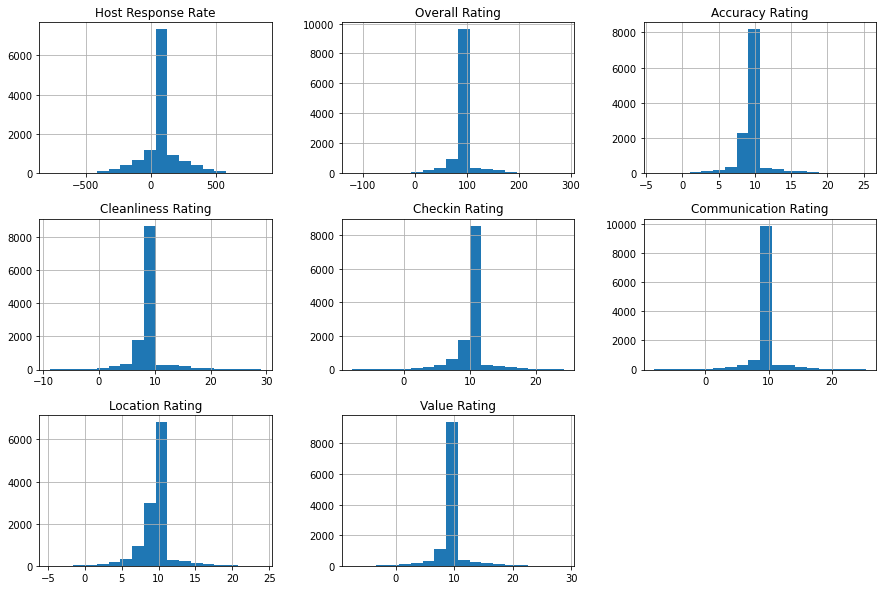

In [40]:
X_train_imputed_df.hist(column=["Host Response Rate",
                                 "Overall Rating",
                                 "Accuracy Rating",
                                 "Cleanliness Rating",
                                 "Checkin Rating",
                                 "Communication Rating",
                                 "Location Rating",
                                 "Value Rating"], bins=18, figsize=(15,10))

New distribution shows this imputation is unusable. Aside from the fact that it has been done with a seemingly predominant constant value around 10/100, the values exceed the 100% mark, which doesn't make sense. 

Results show that simple is best, and a median imputation with standard scaling outputs the best result. 

### Constructing the processed data

In [74]:
# The transformer reorders the features (numeric first then categorical)
# When reconstructing the dataframe, we need to take this into account!
categorical_features = [f for f in list(X_train.columns) if f not in numeric_features]

X_train_processed_arr = airbnb_data_transformer_5.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed_arr, 
                                 columns = numeric_features+categorical_features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfe5a1cd10>,
      dtype=object)

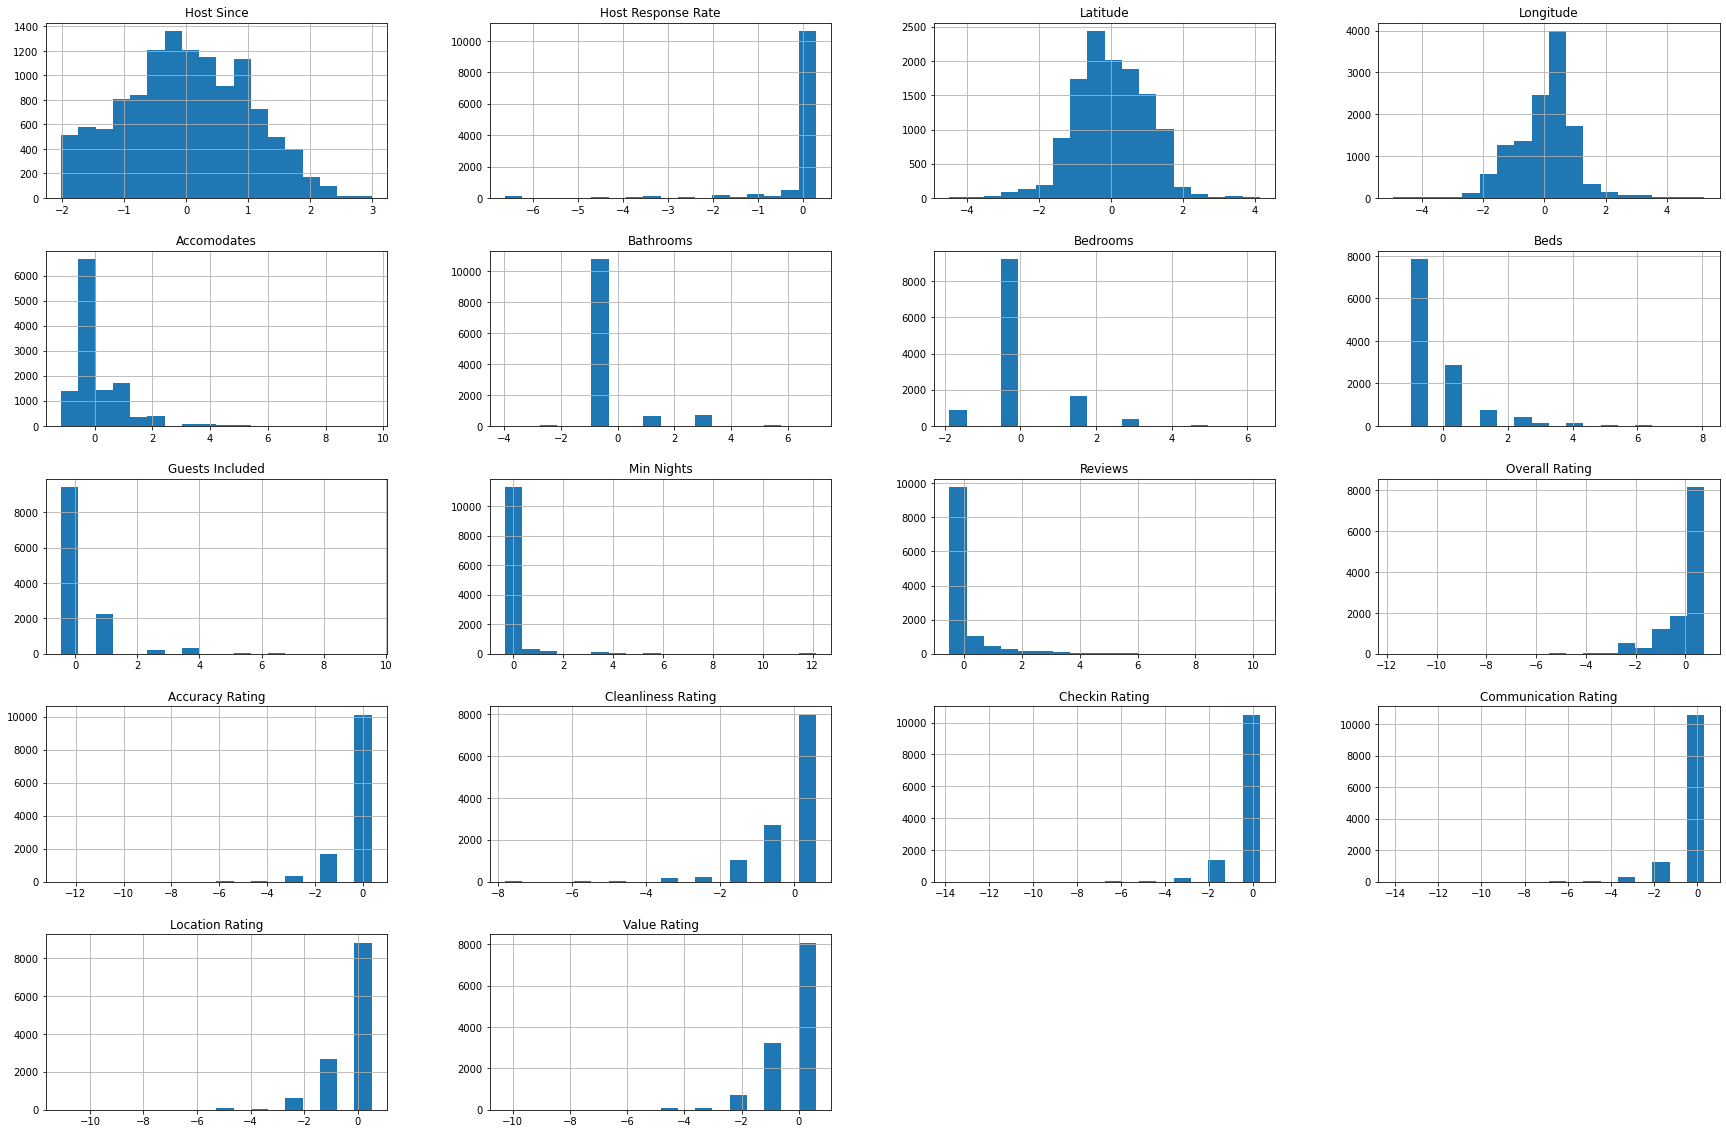

In [76]:
X_train_processed.hist(figsize=(30,20), bins=18,column=numeric_features)

In [83]:
# Likewise, let's build the processed version of X_test as well

categorical_features = [f for f in list(X_test.columns) if f not in numeric_features]

X_test_processed_arr = airbnb_data_transformer_5.fit_transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed_arr, 
                                 columns = numeric_features+categorical_features)

In [85]:
X_train_processed.to_csv("/content/X_train_processed.csv", sep=";", index=False)
X_test_processed.to_csv("/content/X_test_processed.csv", sep=";", index=False)


## Feature Selection

### Best Subset Selection

Let's brute force this by trying every single possible combination.

Caution: we're testing all possible k in 44 features combinations, so too high values of k might not be possible.

In [80]:
# define processing function that given a combination of features, returns its RSS metric

def processSubset(feature_set):
    model=KNeighborsRegressor()
    model.fit(X_train_processed[list(feature_set)], y_train)
    predictions_1 = model.predict(X_test)

    RSS = ((predictions_1 - y_test) ** 2).sum()
    return {"model":list(feature_set), "RSS":RSS}

In [81]:
import itertools
import time
from tqdm import tqdm

def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X_train_processed.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [82]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in tqdm(range(1,8)):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Accomodates
- Accuracy Rating
- Bathrooms
- Bedrooms
- Beds
- ...
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
  0%|          | 0/7 [00:00<?, ?it/s]


ValueError: ignored

### Stepwise selection (forward and backward)

### Arbitrary feature selection

In [55]:
# Let's quickly look at the correlation matrix:

df_clean.drop("Price", axis=1).apply(lambda x: x.corr(df["Price"])).sort_values(ascending=False)


Accomodates                              0.505651
Beds                                     0.421559
Room Type_Entire home/apt                0.420660
Bedrooms                                 0.411953
Guests Included                          0.363908
Bathrooms                                0.253290
Property Type_Loft                       0.164815
Property Type_Serviced apartment         0.105193
Host Response Time_within an hour        0.104374
Location Rating                          0.078324
Is Superhost                             0.076663
Instant Bookable                         0.076663
Is Exact Location                        0.076663
Property Type_Hotel                      0.075534
Reviews                                  0.073858
Cleanliness Rating                       0.070996
Latitude                                 0.046966
Host Response Time_within a few hours    0.045625
Overall Rating                           0.043507
Property Type_Condominium                0.043441


In this first section, we'll focus on selecting the features that contribute most to the variance of the data, in order to limit the number of features.


### PCA